<a href="https://colab.research.google.com/github/omarDrame/KaggleCompetition/blob/main/similarProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic regresssion tools

This project is similar to the compete.ipynb, the data set is also a simple tabular csv file found on Kaggle

**Motivation** : I decided to use some regression tools on this data to get more familiar with some theorical classes I had on machine learning, the data set is quite simple it is from Kaggle.

**Goal**  : Predict the **price** of houses.

# Imports

In [ ]:
# pip install optuna

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from itertools import combinations
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 
import lightgbm as lgbm
import optuna

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/My Drive/Dev/ML/Housing/raw_data.csv',  header=0,encoding='latin1')
target = 'price'
print(f'The data set contains {data.shape[1]} variables and {data.shape[0]} observations')
data.info()

The data set contains 21 variables and 21613 observations
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64

We can extract the features

In [5]:
features = [feature for feature in data.columns if feature not in ['id',target,'date']]
features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [6]:
# Categorical features
features_cat = ['waterfront',
 'view',
 'condition',
 'grade',
 'zipcode',
 'yr_built',
 'yr_renovated']

# Numerical features
features_num = [
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'floors',
 'sqft_basement',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [7]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Visualization

In [8]:
print("size", data.size)
print("shape", data.shape)

size 453873
shape (21613, 21)


## Feature distribution

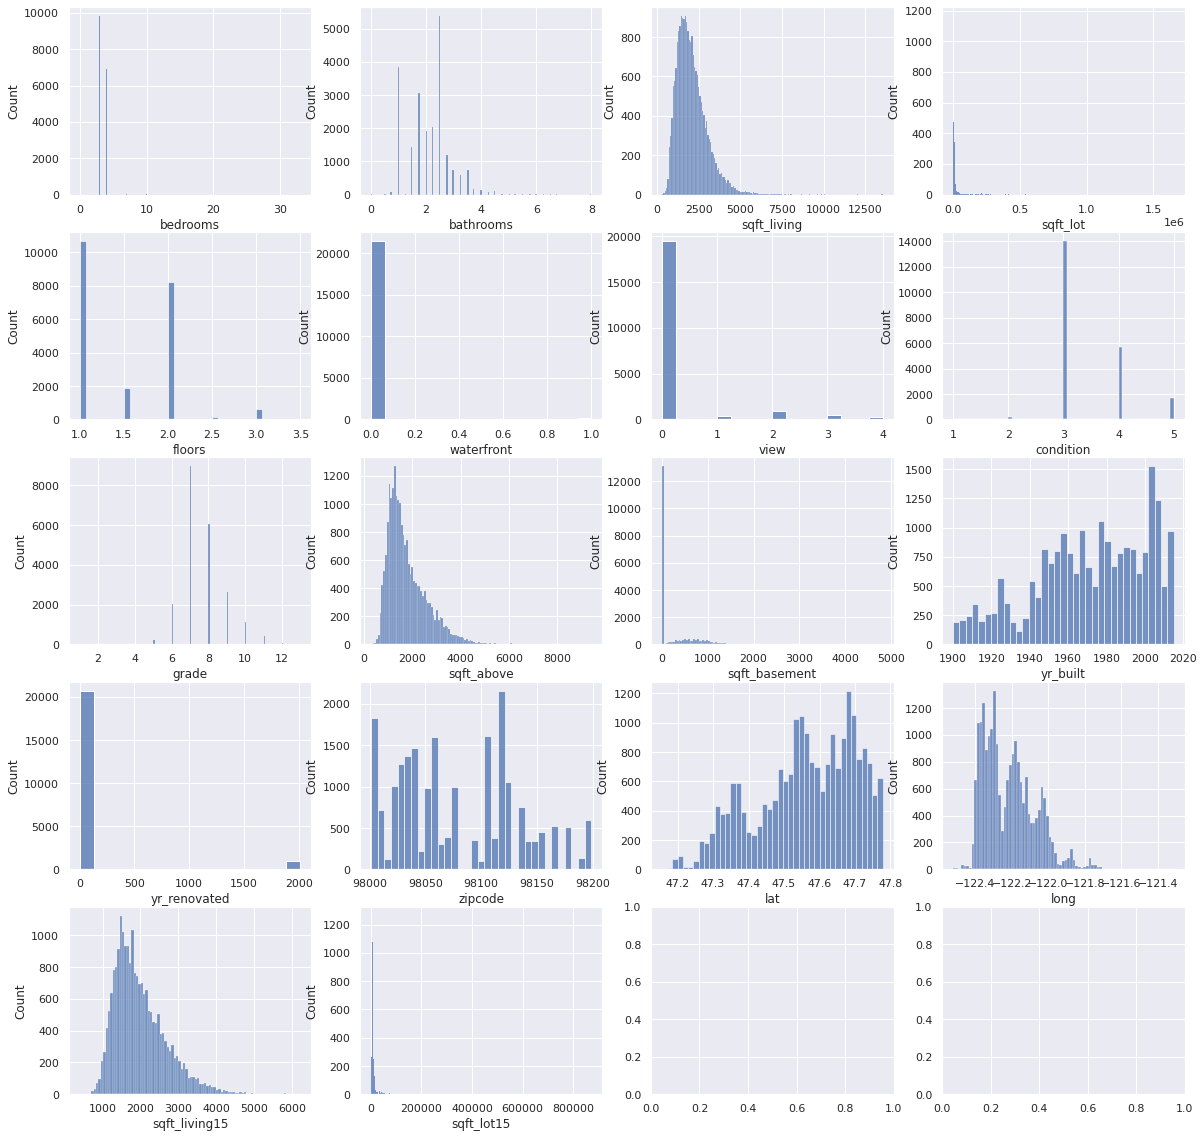

In [9]:

fig, axs = plt.subplots(5,4, figsize=(20,20))

for f, ax in zip(features,axs.ravel()):
    sns.histplot(data, x=f, ax=ax)
plt.show()


## Target distribution

The differences in price are quite huge, to reduce the impact of the bigger value we’re going to use a log  transformation. We see that the distribution is much more balanced.

In [10]:
# print(f'The most expensive {data[target].max()}')

<AxesSubplot:xlabel='price', ylabel='Count'>

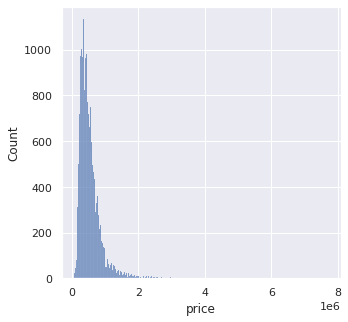

In [11]:
fig, ax = plt.subplots( figsize=(5,5))
sns.histplot(data, x='price', ax=ax)


<AxesSubplot:xlabel='price', ylabel='Count'>

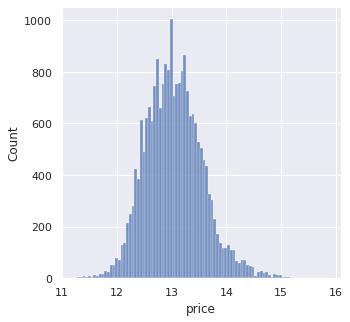

In [12]:
data['price'] = np.log(data['price'])
fig, ax = plt.subplots( figsize=(5,5))
sns.histplot(data, x='price', ax=ax)

# Data preprocessing



## Missing values

In [13]:
print(data.isna().sum())
for clm in data:
  try :
    mean = data[clm].mean()
    data[clm] = data[clm].fillna(mean)
  except : 
    pass
  

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


## Feature ing 

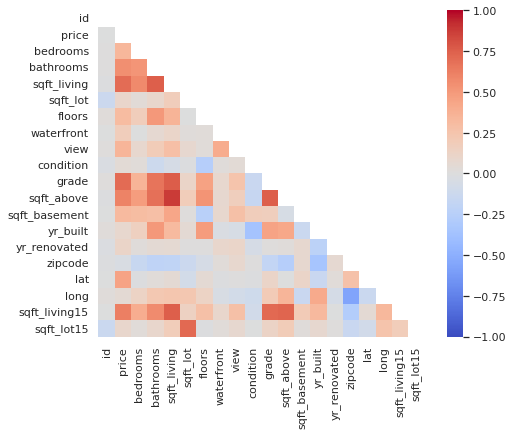

In [14]:
import matplotlib as plt2
mask = np.zeros_like(data.corr())

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt2.pyplot.subplots(figsize=(8, 6))

    ax = sns.heatmap(data.corr(), mask=mask, vmax=1,vmin=-1, square=True, cmap="coolwarm")

In [15]:
"""features.remove('waterfront')

data.drop(['waterfront'],axis=1,inplace=True)"""

"features.remove('waterfront')\n\ndata.drop(['waterfront'],axis=1,inplace=True)"

In [16]:
features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

## Outliers

There are clear outliers in the data set, we're going to remove them using the 3 sigma method.

In [17]:
summary = data[features].describe()
print(summary)

           bedrooms     bathrooms   sqft_living      sqft_lot        floors  \
count  21613.000000  21613.000000  21613.000000  2.161300e+04  21613.000000   
mean       3.370842      2.114757   2079.899736  1.510697e+04      1.494309   
std        0.930062      0.770163    918.440897  4.142051e+04      0.539989   
min        0.000000      0.000000    290.000000  5.200000e+02      1.000000   
25%        3.000000      1.750000   1427.000000  5.040000e+03      1.000000   
50%        3.000000      2.250000   1910.000000  7.618000e+03      1.500000   
75%        4.000000      2.500000   2550.000000  1.068800e+04      2.000000   
max       33.000000      8.000000  13540.000000  1.651359e+06      3.500000   

         waterfront          view     condition         grade    sqft_above  \
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean       0.007542      0.234303      3.409430      7.656873   1788.390691   
std        0.086517      0.766318      0.650743    

<AxesSubplot:>

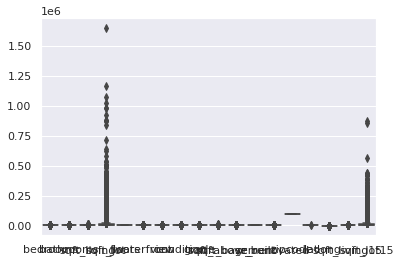

In [18]:
sns.boxplot(data=data[features])

<AxesSubplot:>

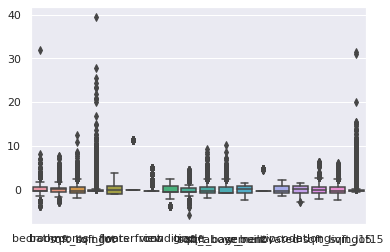

In [19]:
"""scaler = StandardScaler()
data_scaled2 = scaler.fit_transform(data.loc[:,features])"""


from scipy.stats import zscore
# Scaled df
data_normalized = data[features].apply(zscore)

sns.boxplot(data=data_normalized)

In [22]:

outlier_mask = data_normalized[(~(data_normalized<3).all(axis=1))].index
data_normalized =data_normalized.drop(outlier_mask)
data = data.drop(outlier_mask)
outlier_mask


Int64Index([], dtype='int64')

In [23]:
data.reset_index(drop=True)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,12.309982,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,5631500400,20150225T000000,12.100712,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2487200875,20141209T000000,13.311329,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,1954400510,20150218T000000,13.142166,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,1321400060,20140627T000000,12.458775,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18846,263000018,20140521T000000,12.793859,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
18847,6600060120,20150223T000000,12.899220,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
18848,1523300141,20140623T000000,12.904459,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
18849,291310100,20150116T000000,12.899220,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


<AxesSubplot:>

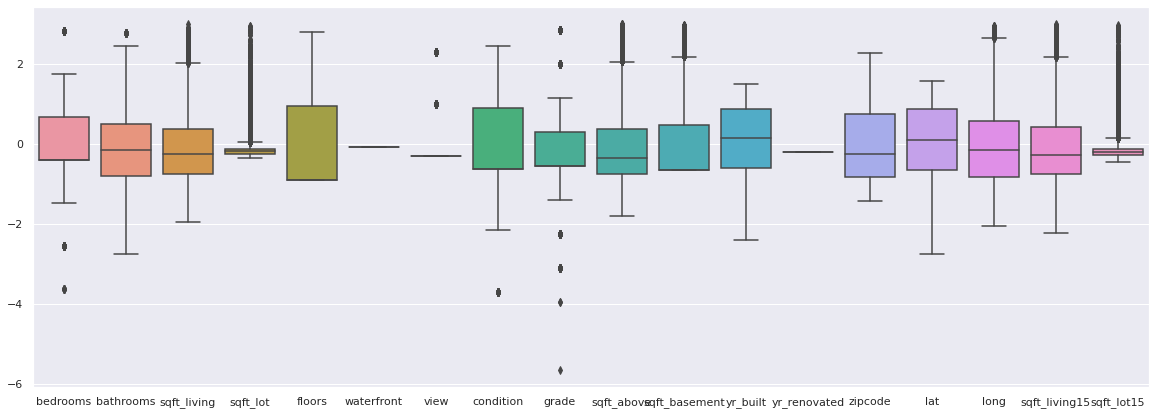

In [24]:
plt.subplots(figsize=(20,7))
sns.boxplot(data=data_normalized[features])

# Modeling

In [26]:
def get_rmse(y_test,y_pred):

  # Calculate the mean squared error
  mse = mean_squared_error(y_test, y_pred)

  # Calculate the root mean squared error
  rmse = sqrt(mse)
  return rmse

## Model selection

Here multiple things were tested. Permutation Importance and linear regression were used to see if the changes would decrease the rmse on a linear regression model, this is how the model selection was basically implemented. 

In [27]:
X = data.loc[:,features]
y = data.loc[:,target]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [28]:
# pip install eli5

In [29]:
"""
import eli5
from eli5.sklearn import PermutationImportance
  
def perm_imp(model,data,target):
    X = data.to_numpy().copy()
    y = target.to_numpy().copy()
    permute = PermutationImportance(model,random_state=2023,n_iter =2,cv=10,scoring='neg_root_mean_squared_error').fit(X, y)
    eli5.show_weights(permute, feature_names = data.columns.tolist(),top=50)
    values = dict(zip(list(data.columns),list(permute.feature_importances_)))
    sorted_dict = {}
    sorted_keys = sorted(values, key=values.get)
    for w in sorted_keys:
        sorted_dict[w] = np.round(values[w],3)
    return sorted_dict

# perm_imp(regressor,X_train,y_train)
"""

"\nimport eli5\nfrom eli5.sklearn import PermutationImportance\n  \ndef perm_imp(model,data,target):\n    X = data.to_numpy().copy()\n    y = target.to_numpy().copy()\n    permute = PermutationImportance(model,random_state=2023,n_iter =2,cv=10,scoring='neg_root_mean_squared_error').fit(X, y)\n    eli5.show_weights(permute, feature_names = data.columns.tolist(),top=50)\n    values = dict(zip(list(data.columns),list(permute.feature_importances_)))\n    sorted_dict = {}\n    sorted_keys = sorted(values, key=values.get)\n    for w in sorted_keys:\n        sorted_dict[w] = np.round(values[w],3)\n    return sorted_dict\n\n# perm_imp(regressor,X_train,y_train)\n"

In [30]:
features.remove('waterfront')

data.drop(['waterfront'],axis=1,inplace=True)

features_cat = [
 'condition',
 'grade',
 'zipcode',
  'view',
 'yr_built',
]

features_num = ['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [31]:
data['sqft_basement'] = data['sqft_basement'].apply(lambda x: np.log(x) if x>0 else 0)
data['sqft_living15'] = np.log(data['sqft_living15'])
data['sqft_living'] = np.log(data['sqft_living'])
data['sqft_lot'] = np.log(data['sqft_lot'])
data['sqft_lot15'] = np.log(data['sqft_lot15'])
data['long'] =  np.log(data['long'] * data['long'])
data['lat'] = np.log(data['lat'] * data['lat'])
data['points']= data['condition'] + data['grade'] + data['yr_built']- data['yr_built'].min() + data['zipcode']- data['zipcode'].min() + data['view']
data.drop((features_cat),axis=1,inplace=True)

features_cat = ['points' ]

In [32]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print(f'rmse linear regression {get_rmse(np.exp(y_pred),np.exp(y_test))}')

# print(f'rmse linear regression {get_rmse(y_pred,y_test)}')
# with  nothing rmse = 190473.37551184202
# transformation log(y) rmse = 175354.54029033447
# Doing outliers rmse = 140226.11385150685
# WIthout waterfront rmse = 132723.8101450237

rmse linear regression 140434.1134834625


## Encoding

In [ ]:
"""
transformer_num = make_pipeline(
    #SimpleImputer(strategy="mean"),
    StandardScaler(),
)

'''
transformer_cat = make_pipeline(
    SimpleImputer(strategy="most_frequent", fill_value="NA"),
    LabelEncoder(),
)
'''


transformer_cat = make_pipeline(
    SimpleImputer(strategy="most_frequent", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)


preprocessor = make_column_transformer(
    (transformer_cat, features_cat),
    (transformer_num, features_num)
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

ohe_feature_names = preprocessor.named_transformers_['pipeline-1'].named_steps['onehotencoder'].get_feature_names_out(features_cat)
feature_names = list(features_num) + list(ohe_feature_names)

# X_train = X_train.toarray()
# X_test = X_test.toarray()
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)
"""



# Regressions

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Hyper parameter Optimization

CV for hyper parameter optimization with a few models using a few optuna trials. For the sake of time many trials were not done but the model can have better performance with more trials (especially random forest and gradient boosting)

### K-NN

In [36]:
def objectiveKnn(trial):
    params_optuna = {'n_neighbors' : trial.suggest_int("n_neighbors", 7, 75),
    'weights' : trial.suggest_categorical("weights", ["uniform", "distance"]),
    'p' : trial.suggest_int("p", 1, 3),
    'leaf_size' : trial.suggest_int("leaf_size", 1, 200),
    'algorithm' : trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"])
    }


    model = KNeighborsRegressor(**params_optuna)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error').mean()

    return -score

In [37]:
"""
study = optuna.create_study(direction='minimize')
study.optimize(func=objectiveKnn, n_trials=100)
study.best_params
"""

"\nstudy = optuna.create_study(direction='minimize')\nstudy.optimize(func=objectiveKnn, n_trials=100)\nstudy.best_params\n"

In [38]:
"""
{'n_neighbors': 23,
 'weights': 'distance',
 'p': 1,
 'leaf_size': 178,
 'algorithm': 'auto'}"""

"\n{'n_neighbors': 23,\n 'weights': 'distance',\n 'p': 1,\n 'leaf_size': 178,\n 'algorithm': 'auto'}"

### Decision trees

In [39]:
def objectiveDT(trial):
    params_optuna = {
    'max_depth' : trial.suggest_int('max_depth', 6, 50),
    'min_samples_split' : trial.suggest_int('min_samples_split', 2, 20),
    'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),
    'min_weight_fraction_leaf' : trial.suggest_int('min_weight_fraction_leaf', 0., 0.9),
    'min_impurity_decrease' : trial.suggest_int('min_impurity_decrease', 0., 0.9)
    }


    model = DecisionTreeRegressor(**params_optuna)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error').mean()

    return -score

In [40]:
"""
study = optuna.create_study(direction='minimize')
study.optimize(func=objectiveDT, n_trials=100)
study.best_params
"""

"\nstudy = optuna.create_study(direction='minimize')\nstudy.optimize(func=objectiveDT, n_trials=100)\nstudy.best_params\n"

In [41]:
"""
{'max_depth': 12,
 'min_samples_split': 20,
 'min_samples_leaf': 8,
 'min_weight_fraction_leaf': 0,
 'min_impurity_decrease': 0}

"""

"\n{'max_depth': 12,\n 'min_samples_split': 20,\n 'min_samples_leaf': 8,\n 'min_weight_fraction_leaf': 0,\n 'min_impurity_decrease': 0}\n\n"

### Random forest

In [42]:
def objectiveRF(trial):        
  params_optuna = {
      'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
      'max_depth': trial.suggest_int('max_depth', 15,50),
      'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
      'min_impurity_decrease': trial.suggest_int('min_impurity_decrease', 0.0 ,0.9),
      'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
      'max_samples': trial.suggest_int('max_samples', 1, 100),}
      
  model = RandomForestRegressor(random_state=42, **params_optuna)

  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=kf, scoring='neg_root_mean_squared_error').mean()

  return -scores

In [43]:
"""
study = optuna.create_study(direction='minimize')
study.optimize(func=objectiveRF, n_trials=100)
study.best_params
"""

"\nstudy = optuna.create_study(direction='minimize')\nstudy.optimize(func=objectiveRF, n_trials=100)\nstudy.best_params\n"

In [44]:
"""
{'n_estimators': 309,
 'max_depth': 36,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0,
 'max_features': 'auto',
 'max_samples': 51}
 """

"\n{'n_estimators': 309,\n 'max_depth': 36,\n 'min_samples_split': 5,\n 'min_samples_leaf': 1,\n 'min_impurity_decrease': 0,\n 'max_features': 'auto',\n 'max_samples': 51}\n "

### L Gradient boosting

In [45]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_train = y_train.to_frame()
y_test = y_test.to_frame()

In [46]:
def objectiveLXB(trial, X_train, y_train, features, target):        
  params_optuna = {
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
      'n_estimators': trial.suggest_int('n_estimators', 50, 800),
      'max_depth': trial.suggest_int('max_depth', 6, 50),
      'reg_alpha    ': trial.suggest_int('reg_alpha    ', 0.0, 0.9),
      'reg_lambda    ': trial.suggest_int('reg_lambda    ', 0.0, 0.9),
      'objective' : "regression"}

  n = trial.suggest_int('n_cv', 3, 10)
  kf = KFold(n_splits=n, shuffle=True, random_state=42)
  fold_scores = []
  for train_index, val_index in kf.split(X_train):
      X_train_cv = X_train.loc[train_index,features]
      y_train_cv = y_train.loc[train_index, target]
      X_val, y_val = X_train.loc[val_index,features],y_train.loc[val_index, target]
      model = lgbm.LGBMRegressor(**params_optuna)
      model.fit(X_train_cv,
                y_train_cv,
                eval_set= [(X_val,y_val)],
                early_stopping_rounds = 50,
                verbose=500)
      pred_val = model.predict(X_val)
      score = get_rmse(y_val,pred_val)
      fold_scores.append(score)
  return np.mean(fold_scores)


In [47]:
"""
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(lambda trial: objectiveLXB(trial, X_train, y_train, features, target), n_trials=100)
study.best_params
"""

"\nsampler = optuna.samplers.TPESampler(seed=42)\nstudy = optuna.create_study(direction='minimize', sampler=sampler)\nstudy.optimize(lambda trial: objectiveLXB(trial, X_train, y_train, features, target), n_trials=100)\nstudy.best_params\n"

In [48]:
"""
{'learning_rate': 0.039998235893948964,
 'n_estimators': 674,
 'max_depth': 11,
 'reg_alpha    ': 0,
 'reg_lambda    ': 0,
 'n_cv': 10}
 """

"\n{'learning_rate': 0.039998235893948964,\n 'n_estimators': 674,\n 'max_depth': 11,\n 'reg_alpha    ': 0,\n 'reg_lambda    ': 0,\n 'n_cv': 10}\n "

### X Gradient boosting

In [49]:
def objectiveXB(trial):        
  params_optuna = {'max_depth': trial.suggest_int('max_depth', 8, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 50, 10000),
            'alpha': trial.suggest_float('alpha', 0.01, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'objective' : "reg:squarederror"}
# { "min_impurity_decrease", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "validation_fraction" } 
  n = trial.suggest_int('n_cv', 3, 10)
  kf = KFold(n_splits=n, shuffle=True, random_state=42)
  fold_scores = []

  for train_index, val_index in kf.split(X_train):
      X_train_cv, y_train_cv = X_train.loc[train_index, features],y_train.loc[train_index, target]
      X_val_cv, y_val_cv = X_train.loc[val_index, features],y_train.loc[val_index, target]
      model = xgb.XGBRegressor(**params_optuna)
      model.fit(X_train,
                y_train,
                eval_set= [(X_val_cv,y_val_cv)],
                early_stopping_rounds = 50,
                verbose=500)
      pred_val = model.predict(X_val_cv)
      score = get_rmse(y_val_cv,pred_val)
      fold_scores.append(score)
  return np.mean(fold_scores)


In [50]:
"""
study = optuna.create_study(direction='minimize')
study.optimize(func=objectiveXB, n_trials=100)
study.best_params
"""

"\nstudy = optuna.create_study(direction='minimize')\nstudy.optimize(func=objectiveXB, n_trials=100)\nstudy.best_params\n"

In [51]:
"""
{'max_depth': 37, 'learning_rate': 0.06533528600930973, 'n_estimators': 3592, 'alpha': 0.026555079799798875, 'subsample': 0.9929787822914418, 'min_samples_split': 0.8538935953087504, 'min_weight_fraction_leaf': 0.03267785509164127, 'min_impurity_decrease': 0.06178215085295332, 'min_samples_leaf': 0.7482042841526495, 'validation_fraction': 0.038473575091008475, 'n_cv': 8}.
 """

"\n{'max_depth': 37, 'learning_rate': 0.06533528600930973, 'n_estimators': 3592, 'alpha': 0.026555079799798875, 'subsample': 0.9929787822914418, 'min_samples_split': 0.8538935953087504, 'min_weight_fraction_leaf': 0.03267785509164127, 'min_impurity_decrease': 0.06178215085295332, 'min_samples_leaf': 0.7482042841526495, 'validation_fraction': 0.038473575091008475, 'n_cv': 8}.\n "

## CV for the models

CV to see how good the model predict compared to the initial linear regression, the best model will be in the ensemble.

### KNN

In [52]:
k = 10
kf = KFold(k, shuffle=True, random_state=42)
oof_preds = []
oof_true = []

for train_index, val_index in kf.split(X_train):                                            
    X_train_cv = X_train.loc[train_index, :]
    y_train_cv = y_train.loc[train_index, :]
    X_val = X_train.loc[val_index, :]
    y_val = y_train.loc[val_index, target]
    params_knn ={'n_neighbors': 23,
 'weights': 'distance',
 'p': 1,
 'leaf_size': 178,
 'algorithm': 'auto'}

    model = KNeighborsRegressor(**params_knn)
    model.fit(X_train_cv,
             y_train_cv)
    pred_val = model.predict(X_val)
    pred_val = np.exp(pred_val)
    y_val = np.exp(y_val)

    score1 = get_rmse(y_val,pred_val)
    
    #out of fold
    oof_preds.extend(pred_val)
    oof_true.extend(y_val)
    print(f'=== Fold RMSE Score {[score1]} ===')
print(f'=== OOF score {get_rmse(oof_preds,oof_true)} ===')

=== Fold RMSE Score [185530.977752147] ===
=== Fold RMSE Score [191343.76559700846] ===
=== Fold RMSE Score [176975.23037224764] ===
=== Fold RMSE Score [180003.04815363232] ===
=== Fold RMSE Score [172286.648729036] ===
=== Fold RMSE Score [178239.96912880492] ===
=== Fold RMSE Score [194056.51159260952] ===
=== Fold RMSE Score [199267.92381201495] ===
=== Fold RMSE Score [187176.89942014933] ===
=== Fold RMSE Score [179289.36057482968] ===
=== OOF score 184595.01277592924 ===


### Decision trees

In [53]:
k = 10
kf = KFold(k, shuffle=True, random_state=42)
oof_preds = []
oof_true = []

for train_index, val_index in kf.split(X_train):                                            
    X_train_cv = X_train.loc[train_index, :]
    y_train_cv = y_train.loc[train_index, :]
    X_val = X_train.loc[val_index, :]
    y_val = y_train.loc[val_index, target]
    params_dt = {'max_depth': 12,
 'min_samples_split': 20,
 'min_samples_leaf': 8,
 'min_weight_fraction_leaf': 0,
 'min_impurity_decrease': 0}
    model = DecisionTreeRegressor(**params_dt)
    model.fit(X_train_cv,
             y_train_cv)
    pred_val = model.predict(X_val)
    pred_val = np.exp(pred_val)
    y_val = np.exp(y_val)
    score1 = get_rmse(y_val,pred_val)

    #out of fold
    oof_preds.extend(pred_val)
    oof_true.extend(y_val)
    print(f'=== Fold RMSE Score {[score1]} ===')
print(f'=== OOF score {get_rmse(oof_preds,oof_true)} ===')

=== Fold RMSE Score [113564.15937232872] ===
=== Fold RMSE Score [115216.4164423664] ===
=== Fold RMSE Score [99868.86183874155] ===
=== Fold RMSE Score [102490.83562691322] ===
=== Fold RMSE Score [100108.19626469079] ===
=== Fold RMSE Score [111703.375153458] ===
=== Fold RMSE Score [112051.60403623067] ===
=== Fold RMSE Score [120995.08929159677] ===
=== Fold RMSE Score [112807.09565325976] ===
=== Fold RMSE Score [102794.30335397902] ===
=== OOF score 109378.50797839781 ===


### Random forest

In [54]:
"""model = RandomForestRegressor(**params_rf)
model.fit(X_train,
          y_train)
pred_val = model.predict(X_train)
pred_val = np.exp(pred_val)
y_val = np.exp(y_train)
score1 = get_rmse(y_val,pred_val)
print(score1)"""

'model = RandomForestRegressor(**params_rf)\nmodel.fit(X_train,\n          y_train)\npred_val = model.predict(X_train)\npred_val = np.exp(pred_val)\ny_val = np.exp(y_train)\nscore1 = get_rmse(y_val,pred_val)\nprint(score1)'

In [55]:
k = 10
kf = KFold(k, shuffle=True, random_state=42)
oof_preds = []
oof_true = []

for train_index, val_index in kf.split(X_train):                                            
    X_train_cv = X_train.loc[train_index, :]
    y_train_cv = y_train.loc[train_index, target].values.ravel()
    X_val = X_train.loc[val_index, :]
    y_val = y_train.loc[val_index, target].values.ravel()
    params_rf ={'n_estimators': 309,
 'max_depth': 36,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0,
 'max_features': 'auto',
 'max_samples': 51}
    model = RandomForestRegressor(**params_rf)
    model.fit(X_train_cv,
             y_train_cv)
    pred_val = model.predict(X_val)
    pred_val = np.exp(pred_val)
    y_val = np.exp(y_val)
    score1 = get_rmse(y_val,pred_val)

    
    #out of fold
    oof_preds.extend(pred_val)
    oof_true.extend(y_val)
    print(f'=== Fold RMSE Score {[score1]} ===')
print(f'=== OOF score {get_rmse(oof_preds,oof_true)} ===')

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


=== Fold RMSE Score [147967.31495459843] ===


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


=== Fold RMSE Score [155149.96115268263] ===


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


=== Fold RMSE Score [135214.45671548296] ===


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


=== Fold RMSE Score [139070.6779820028] ===


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


=== Fold RMSE Score [138828.52882396846] ===


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


=== Fold RMSE Score [142372.59089199986] ===


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


=== Fold RMSE Score [152427.43948602935] ===


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


=== Fold RMSE Score [164839.6738971873] ===


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


=== Fold RMSE Score [144277.32297873535] ===


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


=== Fold RMSE Score [134434.48879052684] ===
=== OOF score 145748.95357209136 ===


### XGB

In [57]:
k=10
kf = KFold(k, shuffle=True, random_state=42)
oof_preds = []
oof_true = []

for train_index, val_index in kf.split(X_train):                                            
    X_train_cv = X_train.loc[train_index, :]
    y_train_cv = y_train.loc[train_index, target]
    X_val = X_train.loc[val_index, :]
    y_val = y_train.loc[val_index, target]
    params_xgb = {'max_depth': 35, 'learning_rate': 0.06533528600930973, 'n_estimators': 3592,
                  'alpha': 0.026555079799798875, 'subsample': 0.9929787822914418, }
    model = xgb.XGBRegressor(**params_xgb)
    model.fit(X_train_cv,
             y_train_cv,
             eval_set= [(X_val,y_val)],
             early_stopping_rounds = 200,
             verbose=1000)
    pred_val = model.predict(X_val)
    pred_val = np.exp(pred_val)
    y_val = np.exp(y_val)
    score1 = get_rmse(y_val,pred_val)

    # 37 85k
    #out of fold
    oof_preds.extend(pred_val)
    oof_true.extend(y_val)
    print(f'=== Fold RMSE Score {[score1]} ===')
print(f'=== OOF score {get_rmse(oof_preds,oof_true)} ===')

[0]	validation_0-rmse:11.67697
[328]	validation_0-rmse:0.16806
=== Fold RMSE Score [91534.98428524398] ===
[0]	validation_0-rmse:11.69764


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[318]	validation_0-rmse:0.16820
=== Fold RMSE Score [94684.61614280894] ===
[0]	validation_0-rmse:11.67414


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[334]	validation_0-rmse:0.16352
=== Fold RMSE Score [79359.88349321498] ===
[0]	validation_0-rmse:11.66821


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[331]	validation_0-rmse:0.16304
=== Fold RMSE Score [84456.5982375432] ===
[0]	validation_0-rmse:11.67839


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[335]	validation_0-rmse:0.16074
=== Fold RMSE Score [77186.39870644036] ===
[0]	validation_0-rmse:11.69016


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[339]	validation_0-rmse:0.16448
=== Fold RMSE Score [90735.22813104893] ===
[0]	validation_0-rmse:11.69468


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[374]	validation_0-rmse:0.16405
=== Fold RMSE Score [95527.72208479667] ===
[0]	validation_0-rmse:11.68661


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[352]	validation_0-rmse:0.16448
=== Fold RMSE Score [91674.67165262083] ===
[0]	validation_0-rmse:11.66745


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[321]	validation_0-rmse:0.17351
=== Fold RMSE Score [96111.3062451594] ===
[0]	validation_0-rmse:11.65730


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[314]	validation_0-rmse:0.16722
=== Fold RMSE Score [83536.2117217686] ===
=== OOF score 88719.12573492223 ===


### LGB

In [58]:
k=10
kf = KFold(k, shuffle=True, random_state=42)
oof_preds = []
oof_true = []

for train_index, val_index in kf.split(X_train):                                            
    X_train_cv = X_train.loc[train_index, :]
    y_train_cv = y_train.loc[train_index, target]
    X_val = X_train.loc[val_index, :]
    y_val = y_train.loc[val_index, target]
    params_lgbm = {'learning_rate': 0.039998235893948964,
    'n_estimators': 674,
    'max_depth': 11,
    'reg_alpha    ': 0,
    'reg_lambda    ': 0,
    'n_cv': 10}
    
    model = lgbm.LGBMRegressor(**params_lgbm)
    model.fit(X_train_cv,
             y_train_cv,
             eval_set= [(X_val,y_val)],
             early_stopping_rounds = 200,
             verbose=1000)
    pred_val = model.predict(X_val)
    pred_val = np.exp(pred_val)
    y_val = np.exp(y_val)
    score1 = get_rmse(y_val,pred_val)
    
    #out of fold
    oof_preds.extend(pred_val)
    oof_true.extend(y_val)
    print(f'=== Fold RMSE Score {[score1]} ===')
print(f'=== OOF score {get_rmse(oof_preds,oof_true)} ===')

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[492]	valid_0's l2: 0.0250599
=== Fold RMSE Score [82988.80061068313] ===
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[597]	valid_0's l2: 0.0251772
=== Fold RMSE Score [90938.20890527741] ===
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[398]	valid_0's l2: 0.0232816
=== Fold RMSE Score [76031.18336830009] ===
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[626]	valid_0's l2: 0.0243751
=== Fold RMSE Score [81766.57024230126] ===
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[665]	valid_0's l2: 0.0240917
=== Fold RMSE Score [74414.47736614107] ===
Training until validation scores don't improve for 200 rounds.
Did not meet early stoppi

## Ensemble

In [59]:
xgbmodel = xgb.XGBRegressor(**params_xgb)
xgbmodel.fit(X_train, y_train)
y_pred_train = xgbmodel.predict(X_train)
y_pred_test = xgbmodel.predict(X_test)

print("On train")
print("R2: %.4f" %r2_score(np.exp(y_train), np.exp(y_pred_train)))
print("RMSE: %.4f" % get_rmse(np.exp(y_train),np.exp(y_pred_train)))
print()
print("On test")
print("R2: %.4f" %r2_score(np.exp(y_test), np.exp(y_pred_test)))
print("RMSE: %.4f" % get_rmse(np.exp(y_test),np.exp(y_pred_test)))
print()

On train
R2: 0.9984
RMSE: 10028.9538

On test
R2: 0.8711
RMSE: 88341.6207



In [60]:
lgbmodel = lgbm.LGBMRegressor(**params_lgbm)
lgbmodel.fit(X_train, y_train)
y_pred_train = lgbmodel.predict(X_train)
y_pred_test =  lgbmodel.predict(X_test)

print("On train")
print("R2: %.4f" %r2_score(np.exp(y_train), np.exp(y_pred_train)))
print("RMSE: %.4f" % get_rmse(np.exp(y_train),np.exp(y_pred_train)))
print()
print("On test")
print("R2: %.4f" %r2_score(np.exp(y_test), np.exp(y_pred_test)))
print("RMSE: %.4f" % get_rmse(np.exp(y_test),np.exp(y_pred_test)))
print()

On train
R2: 0.9474
RMSE: 58278.4052

On test
R2: 0.8848
RMSE: 83516.8052



In [61]:
dtmodel = DecisionTreeRegressor(**params_dt)
dtmodel.fit(X_train, y_train)
y_pred_train = dtmodel.predict(X_train)
y_pred_test = dtmodel.predict(X_test)

print("On train")
print("R2: %.4f" %r2_score(np.exp(y_train), np.exp(y_pred_train)))
print("RMSE: %.4f" % get_rmse(np.exp(y_train),np.exp(y_pred_train)))
print()
print("On test")
print("R2: %.4f" %r2_score(np.exp(y_test), np.exp(y_pred_test)))
print("RMSE: %.4f" % get_rmse(np.exp(y_test),np.exp(y_pred_test)))
print()

On train
R2: 0.8974
RMSE: 81382.2701

On test
R2: 0.8122
RMSE: 106600.1522



# Final Ensemble

The best models are kept and we reache a rmse of 

In [62]:
from sklearn.ensemble import VotingRegressor

xgbmodel = xgb.XGBRegressor(**params_xgb)
lgbmodel = lgbm.LGBMRegressor(**params_lgbm)
dtmodel = DecisionTreeRegressor(**params_dt)
ensemble = VotingRegressor([('gb', xgbmodel), ('rf', lgbmodel)])
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

print("On testing")
print("R2: %.4f" %r2_score(y_test, y_pred))
print("RMSE: %.4f" % get_rmse(y_test,y_pred))
print()


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On testing
R2: 0.8829
RMSE: 84203.0621

